In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:

# using the SQLite Table to read data.
con = sqlite3.connect(r'C:\Sandy\privy\AI\Data Sets\Amazon Food rev dataset\database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

#Took 3000 points from each Category i.e from Positive reviews and Negative Reviews
#Negative Data
Neg_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score < 3 LIMIT 3000""", con) 
#Positive Data
Pos_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score > 3 LIMIT 3000""", con) 

Neg_data.head()
filtered_data =pd.concat([Neg_data,Pos_data])
print("Total Sample Points : ",filtered_data.shape)
#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)
print("\n Sample Points : ")
filtered_data.head()

Total Sample Points :  (6000, 10)

 Sample Points : 


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
1,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
2,13,B0009XLVG0,A327PCT23YH90,LT,1,1,1,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...
3,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,1348099200,poor taste,I love eating them and they are good for watch...
4,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan..."


In [41]:


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our dataset", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (6000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
1,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
2,13,B0009XLVG0,A327PCT23YH90,LT,1,1,0,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...


In [44]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [45]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [46]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [47]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [49]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [50]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(5873, 10)

In [51]:
#Checking to see how much % of data still remains

(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

97.88333333333334

In [52]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [53]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [54]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(5873, 10)


1    2994
0    2879
Name: Score, dtype: int64

In [55]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [56]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [58]:
# Combining all the above stundents 
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 5873/5873 [00:03<00:00, 1917.23it/s]


In [59]:
print(preprocessed_reviews[1])

used victor fly bait seasons ca not beat great product


<h2>BOW with 20 sample Points</h2>

In [65]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])



some feature names  ['aa', 'aahhhs', 'aback', 'abandoned', 'abates', 'abby', 'abc', 'abdomen', 'abdominal', 'abide']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5873, 14923)
the number of unique words  14923


In [68]:
print("first vector is ",final_counts[0])

first vector is    (0, 849)	1
  (0, 2989)	1
  (0, 5123)	1
  (0, 5497)	1
  (0, 8637)	1
  (0, 10131)	1
  (0, 10217)	1
  (0, 11128)	1
  (0, 12598)	1
  (0, 13557)	1
  (0, 13641)	1
  (0, 14007)	1
  (0, 14261)	1


<h2>TSNE Implementation(BOW) with 20 sample Points</h2>

    Dimension_x  Dimension_y  Score
1     47.533840    -1.048463    1.0
2     16.947844   -31.575644    1.0
3    -26.929747    20.732336    1.0
4     -4.395844   -32.922810    1.0
5     27.327641    35.805267    1.0
6     21.456394    16.117622    0.0
7    -21.427845   -19.114166    0.0
8     41.190418    19.893555    0.0
9      6.972011    25.294550    0.0
10    -0.793375   -13.779734    0.0
11   -12.198659    -0.359586    0.0
12    28.322632     0.344556    0.0
13    16.103151   -11.880673    0.0
14     7.838866    44.811310    0.0
15   -31.785879     0.133858    0.0
16    35.416283   -20.160290    0.0
17    -7.743803    16.121630    0.0
18   -12.220153    36.350624    0.0


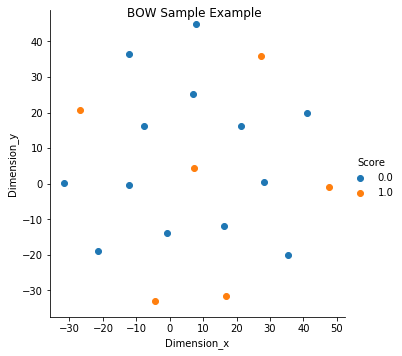

In [72]:
from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0)
X_embedding=model.fit_transform(final_counts[1:20].toarray())
#APPlied AI learning
tsne_data=np.vstack((X_embedding.T,final['Score'][1:20])).T
for_tsne_df = pd.DataFrame(data=tsne_data, columns=['Dimension_x','Dimension_y','Score'])
g=sns.FacetGrid(for_tsne_df,hue='Score',height=5).map(plt.scatter,'Dimension_x','Dimension_y').add_legend()
#https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot/29814281
g.fig.suptitle('BOW Sample Example')
print(for_tsne_df[1:20])

<h4>By above plot we can visualize that data is randomly distrubuted and cannot  differentiate the space over positive and negative points</h4>

<h2>BOW with bi-gram</h2>

In [70]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
#min-df ignore terms that have a document frequency strictly lower than the given threshold.
#max_features build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.shape[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5873, 3877)
the number of unique words including both unigrams and bigrams  3877


<h2>TSNE(BOW) implementation</h2>

Text(0.5, 0.98, 'TSNE with BOW')

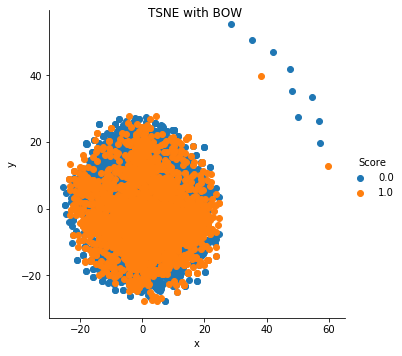

In [71]:
from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0)
X_embedding=model.fit_transform(final_counts.toarray())
#Applied AI learning
tsne_data=np.vstack((X_embedding.T,final['Score'])).T
for_tsne_df = pd.DataFrame(data=tsne_data, columns=['x','y','Score'])
#APPlied AI Bi-variate analysys
g=sns.FacetGrid(for_tsne_df,hue='Score',height=5).map(plt.scatter,'x','y').add_legend()
#https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot/29814281
g.fig.suptitle('TSNE with BOW')
#print(for_tsne_df[1:20])

<font size=3> Here we cannot predict or visualie a a line which segrgates the Scores(i.e positive or negative)</font>
<br/>

<h2><strong>TSNE(BOW with bigram) Implementation</strong>

388.993488073349


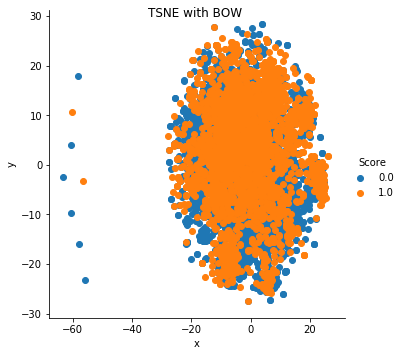

In [73]:
import time
start = time. time()
from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0)
X_embedding=model.fit_transform(final_bigram_counts.toarray())
#Applied AI learning
tsne_data=np.vstack((X_embedding.T,final['Score'])).T
for_tsne_df = pd.DataFrame(data=tsne_data, columns=['x','y','Score'])
g=sns.FacetGrid(for_tsne_df,hue='Score',height=5).map(plt.scatter,'x','y').add_legend()
#https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot/29814281
g.fig.suptitle('TSNE with BOW')
#print(for_tsne_df[1:20])
end = time. time()
print(end - start)

<h2>TSNE(BOW with Trigram) Implementation</h2>

In [74]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,3), min_df=10, max_features=5000)
final_bigram_counts3 = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5873, 3877)
the number of unique words including both unigrams and bigrams  3877


362.6028325557709


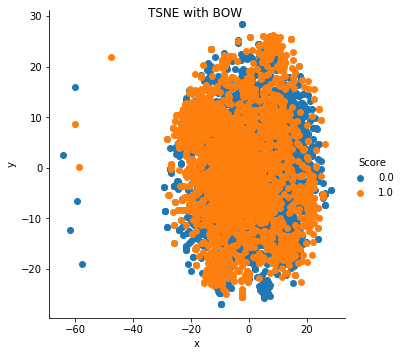

In [75]:
import time
start = time.time()
from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0)
X_embedding=model.fit_transform(final_bigram_counts3.toarray())
#Applied AI learning
tsne_data=np.vstack((X_embedding.T,final['Score'])).T
for_tsne_df = pd.DataFrame(data=tsne_data, columns=['x','y','Score'])
g=sns.FacetGrid(for_tsne_df,hue='Score',height=5).map(plt.scatter,'x','y').add_legend()
#https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot/29814281
g.fig.suptitle('TSNE with BOW')
#print(for_tsne_df[1:20])
end = time.time()
print(end - start)

<h2>T-SNE with TF-IDF</h2>

In [76]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'accept']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5873, 3877)
the number of unique words including both unigrams and bigrams  3877


335.3896152973175


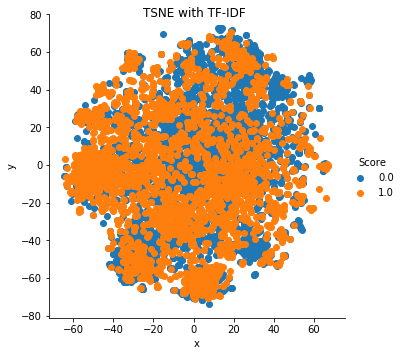

In [77]:
import time
start = time.time()
from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0)
X_embedding=model.fit_transform(final_tf_idf.toarray())
#Applied AI learning
tsne_data=np.vstack((X_embedding.T,final['Score'])).T
for_tsne_df = pd.DataFrame(data=tsne_data, columns=['x','y','Score'])
g=sns.FacetGrid(for_tsne_df,hue='Score',height=5).map(plt.scatter,'x','y').add_legend()
#https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot/29814281
g.fig.suptitle('TSNE with TF-IDF')
end = time.time()
print(end - start)

<h2>TSNE with word to vec</h2>

In [101]:
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())
print(list_of_sentance[1:10])
print('\n')
print(type(preprocessed_reviews))

[['used', 'victor', 'fly', 'bait', 'seasons', 'ca', 'not', 'beat', 'great', 'product'], ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'decals', 'car', 'window', 'everybody', 'asks', 'bought', 'decals', 'made', 'two', 'thumbs'], ['received', 'shipment', 'could', 'hardly', 'wait', 'try', 'product', 'love', 'slickers', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'use', 'car', 'windows', 'printed', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'product', 'windows', 'everywhere', 'surfaces', 'like', 'tv', 'screens', 'computer', 'monitors'], ['glad', 'cocker', 'standard', 'poodle', 'puppy', 'loves', 'stuff', 'trust', 'brand', 'superior', 'nutrition', 'compare', 'labels', 'previous', 'feed', 'pedigree', 'mostly', 'corn', 'little', 'dude', 'healthy', 'happy', 'high', 'energy', 'glossy', 'coat', 'also', 'superior', 'nutrition', 'produces', 'smaller', 'compact', 'stools'], ['using', 'food', 

In [81]:
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4506
sample words  ['product', 'available', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'ca', 'not', 'beat', 'great', 'really', 'good', 'idea', 'final', 'outstanding', 'use', 'car', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'windows', 'print', 'shop', 'program', 'going', 'lot']


In [85]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero's with length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
print(sent_vectors[0:1])

100%|██████████| 5873/5873 [00:08<00:00, 658.76it/s]


5873
50
[array([ 0.1525359 , -0.62744745,  0.52472873, -0.27241544,  0.14966254,
       -0.39644233,  0.48789565,  0.0015135 , -0.39131813,  0.01530557,
        0.35525566, -0.28522921, -0.05777501, -0.27065225,  0.03089993,
       -0.08066183,  0.38462851,  0.55563261,  0.08326235, -0.24288433,
       -0.00324191,  0.07570929,  0.17412864, -0.24991199, -0.36722103,
        0.0779019 ,  0.64432961,  0.27008459,  0.00591411, -0.05998786,
        0.11583283, -0.32985068,  0.52553442,  0.02068581, -0.41303387,
        0.36133172, -0.23856224,  0.27659468, -0.55712601,  0.52464679,
        0.03851868, -0.08190021,  0.26804303, -0.22408732,  0.40699712,
        0.38733752,  0.33414323, -0.0607787 ,  0.26856936,  0.41334341])]


101.93248295783997


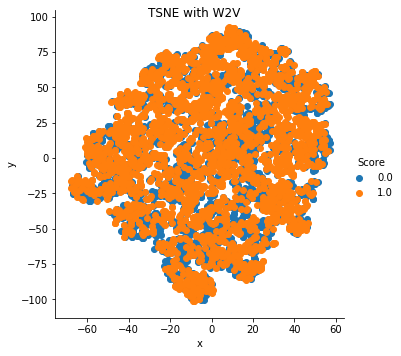

In [87]:
import time
start = time.time()
from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0)
X_embedding=model.fit_transform(sent_vectors)
#Applied AI learning
tsne_data=np.vstack((X_embedding.T,final['Score'])).T
for_tsne_df = pd.DataFrame(data=tsne_data, columns=['x','y','Score'])
g=sns.FacetGrid(for_tsne_df,hue='Score',height=5).map(plt.scatter,'x','y').add_legend()
#https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot/29814281
g.fig.suptitle('TSNE with W2V')
#print(for_tsne_df[1:20])
end = time.time()
print(end - start)

In [92]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [94]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 5873/5873 [00:59<00:00, 98.94it/s] 


In [96]:
print(tfidf_sent_vectors[0:1])

[array([ 0.13974505, -0.55714064,  0.46484216, -0.22281855,  0.13737088,
       -0.34302053,  0.43661114,  0.00430282, -0.3376963 ,  0.03347259,
        0.29675686, -0.25173992, -0.05566038, -0.24536326,  0.02151735,
       -0.07293872,  0.34343102,  0.49180235,  0.07343349, -0.20915471,
       -0.00986948,  0.06860271,  0.14925795, -0.22424151, -0.33002456,
        0.0817408 ,  0.56608569,  0.23630838, -0.00252105, -0.05884005,
        0.10677823, -0.27940819,  0.46686405,  0.01556381, -0.37600343,
        0.31724785, -0.20182131,  0.23008624, -0.49810311,  0.4576221 ,
        0.0361226 , -0.07244837,  0.23355375, -0.1971585 ,  0.35185873,
        0.34700864,  0.30291627, -0.05453237,  0.23134542,  0.36313557])]


81.7252299785614


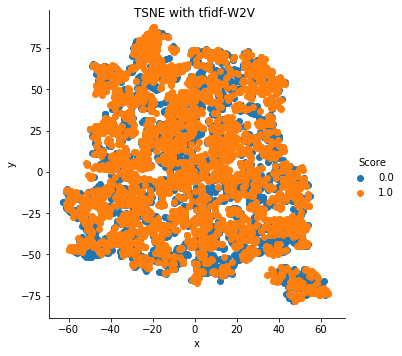

In [97]:
import time
start = time.time()
from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0)
X_embedding=model.fit_transform(tfidf_sent_vectors)
#Applied AI learning
tsne_data=np.vstack((X_embedding.T,final['Score'])).T
for_tsne_df = pd.DataFrame(data=tsne_data, columns=['x','y','Score'])
g=sns.FacetGrid(for_tsne_df,hue='Score',height=5).map(plt.scatter,'x','y').add_legend()
#https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot/29814281
g.fig.suptitle('TSNE with tfidf-W2V')
#print(for_tsne_df[1:20])
end = time.time()
print(end - start)

<p>
1)With BOW Implementation, we are not able to seperate the Positive and Negative points.
2)With TF-IDF Implementation, we are not able to seperate the Positive and Negative points.
3)With Avg Weighted W2V Implementation we are not able to seperate the Positive and Negative points.
4)With TF-IDF weighted W2V Implementation we are not able to seperate the Positive and Negative points.
    </p>

<h3>Conclusion:</h3>
    <p>By using TSNE we are not able to differentiate the positive and negative points and need to use other enhanced techniques for  more understandings on the Data</p>